In [343]:
from scipy import stats
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [344]:
import matplotlib.pyplot as plt
import seaborn as sns

In [345]:
L21 = 0.1
L31 = -0.6
L41 = -0.7
L51 = 0
L61 = 0.4
L71 = 0.2
L32 = 0
L42 = -0.1
L52 = 0.4
L62 = 0.1
L72 = 0.1
L43 = 0.2
L53 = -0.4
L63 = 0.6
L73 = 0.01
L54 = 0.4
L64 = 0.1
L74 = -0.3
L65 = 0.3
L75 = 0.5
L76 = 0.2

In [346]:
L11 = 1

if 1-L21**2 >=0:
    L22 = np.sqrt(1-L21**2)
else:
    raise ValueError('1-L21**2 must be >=0')

if 1-L31**2-L32**2 >=0:
    L33 = np.sqrt(1-L31**2-L32**2)
else:
    raise ValueError('1-L31**2-L32**2 must be >=0')

if 1-L41**2-L42**2-L43**2 >=0:
    L44 = np.sqrt(1-L41**2-L42**2-L43**2)
else:
    raise ValueError('1-L41**2-L42**2-L43**2 must be >=0')

if 1-L51**2-L52**2-L53**2-L54**2 >=0:
    L55 = np.sqrt(1-L51**2-L52**2-L53**2-L54**2)
else:
    raise ValueError('1-L51**2-L52**2-L53**2-L54**2 must be >=0')

if 1-L61**2-L62**2-L63**2-L64**2-L65**2 >=0:
    L66 = np.sqrt(1-L61**2-L62**2-L63**2-L64**2-L65**2)
else:
    raise ValueError('1-L61**2-L62**2-L63**2-L64**2-L65**2 must be >=0')

if 1-L71**2-L72**2-L73**2-L74**2-L75**2-L76**2 >=0:
    L77 = np.sqrt(1-L71**2-L72**2-L73**2-L74**2-L75**2-L76**2)
else:
    raise ValueError('1-L71**2-L72**2-L73**2-L74**2-L75**2-L76**2 must be >=0')

In [347]:
L = [[L11, 0, 0, 0, 0, 0, 0],
     [L21, L22, 0, 0, 0, 0, 0],
     [L31, L32, L33, 0, 0, 0, 0],
     [L41, L42, L43, L44, 0, 0, 0],
     [L51, L52, L53, L54, L55, 0, 0],
     [L61, L62, L63, L64, L65, L66, 0],
     [L71, L72, L73, L74, L75, L76, L77]]

In [348]:
covmat_Z = np.dot(L, np.transpose(L))

# The covariance (=correlation here) matrix must be non-singular and positive semi-definite: verification
if not np.all(np.linalg.eigvals(covmat_Z) >= 0):
    raise ValueError('The covariance matrix is not positive semi-definite')
if round(np.linalg.det(covmat_Z), 6) == 0:
    raise ValueError('The covariance matrix is singular')
# All entries must be in [-1,1]
if not np.all(np.abs(covmat_Z <= 1)):
    raise ValueError('All entries of the correlation matrix must be in [-1,1]')

In [349]:
mvnorm = stats.multivariate_normal(mean=np.zeros(covmat_Z.shape[0]), cov=covmat_Z)

m1 = stats.norm(2,0.6)
m2 = stats.norm(0.2,0.3)
m3 = stats.norm(-0.3,2)
m4 = stats.norm(0.7,0.4)
m5 = stats.uniform()
m6 = stats.uniform()
m7 = stats.uniform()

p_a = 0.3
tau_a = 1 - p_a

p_b = 0.9
tau_b = 1-p_b

p_y = 0.2
tau_y = 1 - p_y

In [350]:
!mkdir bias_data

datasets=[]
for i in tqdm(range(100)):
    z = mvnorm.rvs(100000)
    u = stats.norm.cdf(z)
    x1 = m1.ppf(u[:, 0])
    x2 = m2.ppf(u[:, 1])
    x3 = m3.ppf(u[:, 2])
    x4 = m4.ppf(u[:, 3])
    x5 = m5.ppf(u[:, 4])
    x6 = m6.ppf(u[:, 5])
    x7 = m7.ppf(u[:, 6])
    a = np.zeros(len(x5), dtype=int)
    a[x5 >= tau_a] = 1
    b = np.zeros(len(x6), dtype=int)
    b[x6 >= tau_b] = 1
    y = np.zeros(len(x7), dtype=int)
    y[x7 >= tau_y] = 1
    data = pd.DataFrame({'X1':x1, 'X2':x2, 'X3':x3, 'X4':x4, 'A':a, 'B':b, 'Y':y})
    data.to_csv('bias_data/synthetic_data_v2010_' + str(i) + '.csv', index=False)
    datasets.append(data)

mkdir: cannot create directory ‘bias_data’: File exists


100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


In [351]:
datasets[0]

,X1,X2,X3,X4,A,B,Y
0,2.100152,0.548795,-2.501585,0.078221,0,1,1
1,2.460451,0.449642,-0.266886,0.429586,0,1,1
2,1.794899,-0.006206,2.453702,0.975633,0,1,0
3,2.323713,-0.217512,0.670866,0.383962,0,1,1
4,1.868454,0.007866,2.801322,0.961400,0,1,0
...,...,...,...,...,...,...,...
99995,2.102324,0.371908,-2.218771,0.524309,0,1,0
99996,2.558575,0.628152,-2.222029,0.209305,0,1,0
99997,1.355737,0.218765,1.135686,1.087352,1,1,0
99998,2.431048,0.635648,1.327297,0.661152,0,1,1


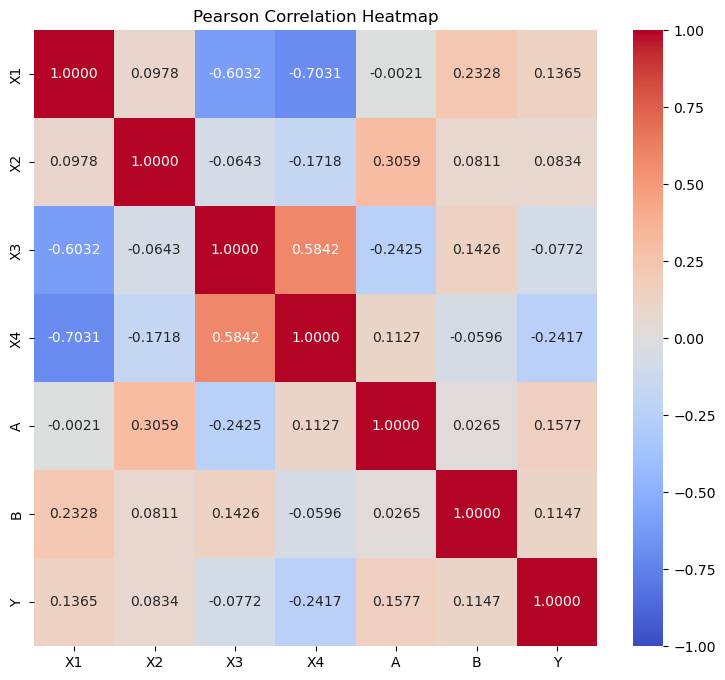

In [352]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[0].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

In [413]:
class Encoder(nn.Module):
    def __init__(self, input_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim-2)
        self.relu = nn.ReLU()
    def forward(self, x):
#         return self.relu(self.fc1(x))
        return self.fc1(x)

In [414]:
class Predictor(nn.Module):
    def __init__(self, input_dim):
        super(Predictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        return self.sigmoid(self.fc1(x))

In [415]:
class Adversary(nn.Module):
    def __init__(self, input_dim):
        super(Adversary, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        return self.sigmoid(self.fc1(x))

In [416]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.X = torch.tensor(dataframe[['X1', 'X2', 'X3', 'X4', 'A', 'B']].values, dtype=torch.float32)
#         self.A = torch.tensor(dataframe[['A']].values, dtype=torch.float32)
#         self.B = torch.tensor(dataframe[['B']].values, dtype=torch.float32)
        self.Y = torch.tensor(dataframe[['Y']].values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
#         return self.X[idx], self.A[idx], self.B[idx], self.Y[idx]
        return self.X[idx], self.Y[idx]

dataset = CustomDataset(datasets[0])
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [417]:
encoder = Encoder(6)
predictor = Predictor(4)
adversaryA = Adversary(4)
adversaryB = Adversary(4)

In [418]:
learning_rate = 0.01

criterion_enc = nn.MSELoss()
criterion_pred = nn.BCELoss()
criterion_advA = nn.BCELoss()
criterion_advB = nn.BCELoss()

optimizer_pred = optim.Adam(predictor.parameters(), lr=learning_rate)
optimizer_advA = optim.Adam(adversaryA.parameters(), lr=learning_rate)
optimizer_advB = optim.Adam(adversaryB.parameters(), lr=learning_rate)
optimizer_enc = optim.Adam(encoder.parameters(), lr=learning_rate)

In [419]:
for a,b in dataloader:
    print(a.shape)
    print(b.shape)
    break

torch.Size([256, 6])
torch.Size([256, 1])


In [420]:
num_epochs = 5
encoder.train()

gradient_norms_enc = []
epochs_enc = []

In [421]:
for epoch in range(num_epochs):

    total_gradient_norm = 0.0
    num_batches = 0

    for data, labels in dataloader: 
        encoder.zero_grad()
        x_recon = encoder(data)
        lx = criterion_enc(x_recon, data[:,:4])
        lx.backward()

        batch_gradient_norm = 0.0
        for p in encoder.parameters():
            if p.grad is not None:
                batch_gradient_norm += p.grad.data.norm(2).item() ** 2
        batch_gradient_norm = batch_gradient_norm ** 0.5
        total_gradient_norm += batch_gradient_norm
        num_batches += 1

        optimizer_enc.step()
    
    average_gradient_norm = total_gradient_norm / num_batches
    gradient_norms_enc.append(average_gradient_norm)
    epochs_enc.append(epoch)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss Recon: {lx.item():.4f}')

Epoch [1/5], Loss Recon: 0.0223
Epoch [2/5], Loss Recon: 0.0057
Epoch [3/5], Loss Recon: 0.0017
Epoch [4/5], Loss Recon: 0.0005
Epoch [5/5], Loss Recon: 0.0002


In [422]:
gradient_norms_enc

[0.5611585236160881,
 0.04143276310966121,
 0.019618600527533253,
 0.009362139732569854,
 0.00479284117598758]

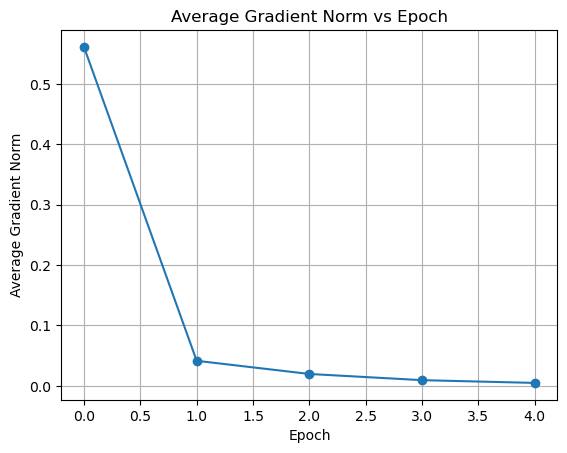

In [423]:
plt.plot(epochs_enc, gradient_norms_enc, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

In [424]:
# index = 0
# df_original = datasets[index].copy()

# dataset = CustomDataset(df_original)
# dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# encoder_outputs = []
# encoder.eval()
# with torch.no_grad():
#     for batch_X, _ in dataloader:
#         output = encoder(batch_X)
#         encoder_outputs.append(output)
# encoder_outputs = torch.cat(encoder_outputs, dim=0)

# encoder_outputs_np = encoder_outputs.numpy()
# df = pd.DataFrame(encoder_outputs_np, columns=['X1', 'X2', 'X3', 'X4'])

# df_A_B = df_original[['A', 'B', 'Y']].reset_index(drop=True)
# df = pd.concat([df, df_A_B], axis=1)

# correlation_matrix = df.corr()

# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
# plt.title('Pearson Correlation Heatmap')
# plt.show()

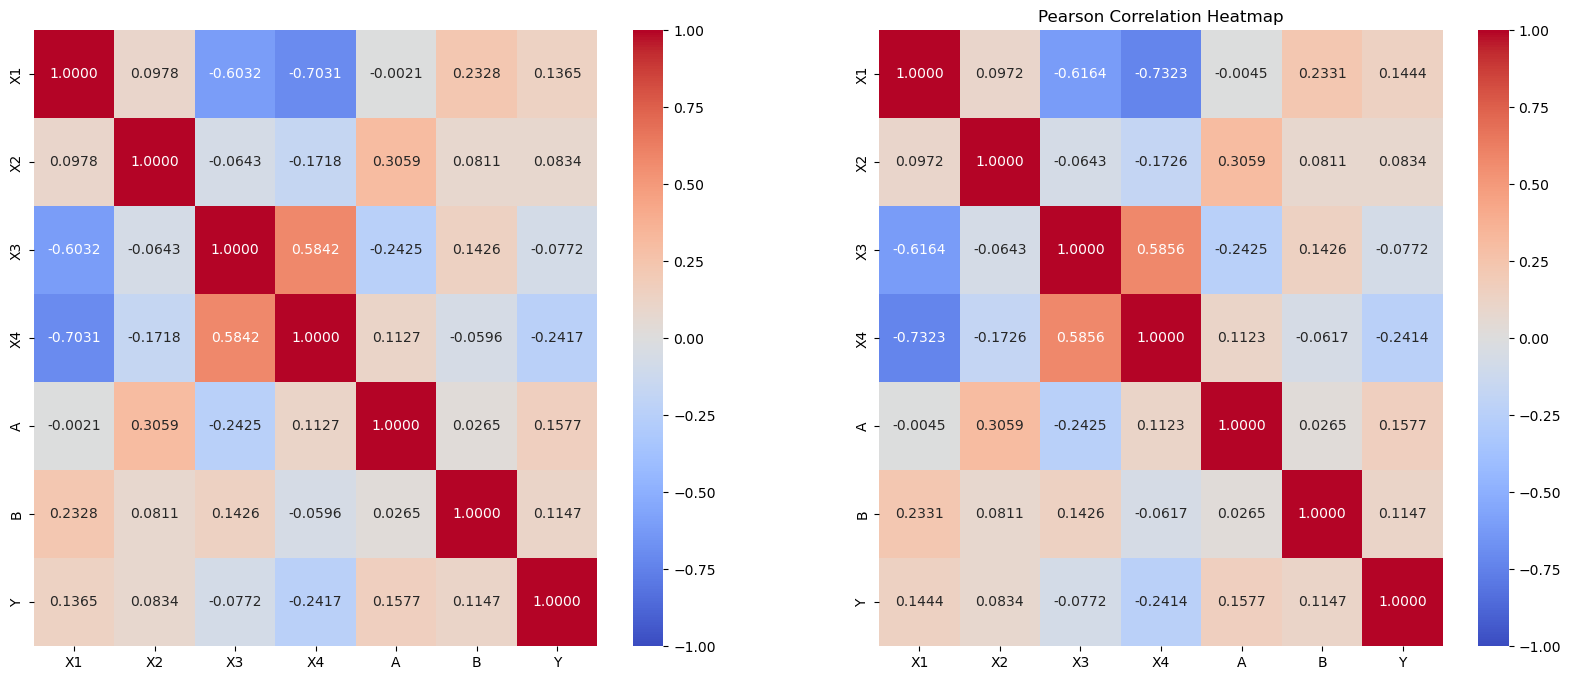

In [425]:
index = 0
df = pd.DataFrame(encoder(torch.tensor(datasets[index][['X1','X2','X3','X4','A','B']].values, dtype=torch.float32)).detach().numpy(), columns=['X1', 'X2', 'X3', 'X4'])
df_A_B_Y = datasets[index].copy()[['A', 'B', 'Y']].reset_index(drop=True)
df = pd.concat([df, df_A_B_Y], axis=1)
correlation_matrix = df.corr()
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[index].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

In [426]:
num_epochs = 30
predictor.train()

gradient_norms_pred = []
epochs_pred = []

In [427]:
for epoch in range(num_epochs):

    total_gradient_norm = 0.0
    num_batches = 0

    for data, labels in dataloader: 
        predictor.zero_grad()
        x_recon = encoder(data)
        y_pred = predictor(x_recon.detach())
        lp = criterion_pred(y_pred, labels)
        lp.backward()
        
        batch_gradient_norm = 0.0
        for p in predictor.parameters():
            if p.grad is not None:
                batch_gradient_norm += p.grad.data.norm(2).item() ** 2
        batch_gradient_norm = batch_gradient_norm ** 0.5
        total_gradient_norm += batch_gradient_norm
        num_batches += 1

        optimizer_pred.step()
    
    average_gradient_norm = total_gradient_norm / num_batches
    gradient_norms_pred.append(average_gradient_norm)
    epochs_pred.append(epoch)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss Pred: {lp.item():.4f}')

Epoch [1/30], Loss Pred: 0.5403
Epoch [2/30], Loss Pred: 0.4099
Epoch [3/30], Loss Pred: 0.4931
Epoch [4/30], Loss Pred: 0.4919
Epoch [5/30], Loss Pred: 0.3972
Epoch [6/30], Loss Pred: 0.4747
Epoch [7/30], Loss Pred: 0.5763
Epoch [8/30], Loss Pred: 0.4555
Epoch [9/30], Loss Pred: 0.4852
Epoch [10/30], Loss Pred: 0.5439
Epoch [11/30], Loss Pred: 0.5656
Epoch [12/30], Loss Pred: 0.5469
Epoch [13/30], Loss Pred: 0.4774
Epoch [14/30], Loss Pred: 0.4650
Epoch [15/30], Loss Pred: 0.4212
Epoch [16/30], Loss Pred: 0.5150
Epoch [17/30], Loss Pred: 0.5671
Epoch [18/30], Loss Pred: 0.4504
Epoch [19/30], Loss Pred: 0.3346
Epoch [20/30], Loss Pred: 0.4943
Epoch [21/30], Loss Pred: 0.4641
Epoch [22/30], Loss Pred: 0.4261
Epoch [23/30], Loss Pred: 0.5024
Epoch [24/30], Loss Pred: 0.4694
Epoch [25/30], Loss Pred: 0.4446
Epoch [26/30], Loss Pred: 0.5875
Epoch [27/30], Loss Pred: 0.5208
Epoch [28/30], Loss Pred: 0.4904
Epoch [29/30], Loss Pred: 0.4257
Epoch [30/30], Loss Pred: 0.5253


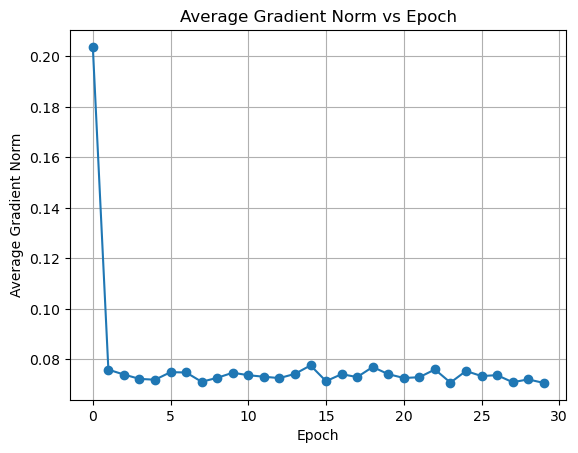

In [428]:
plt.plot(list(range(num_epochs)), gradient_norms_pred, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

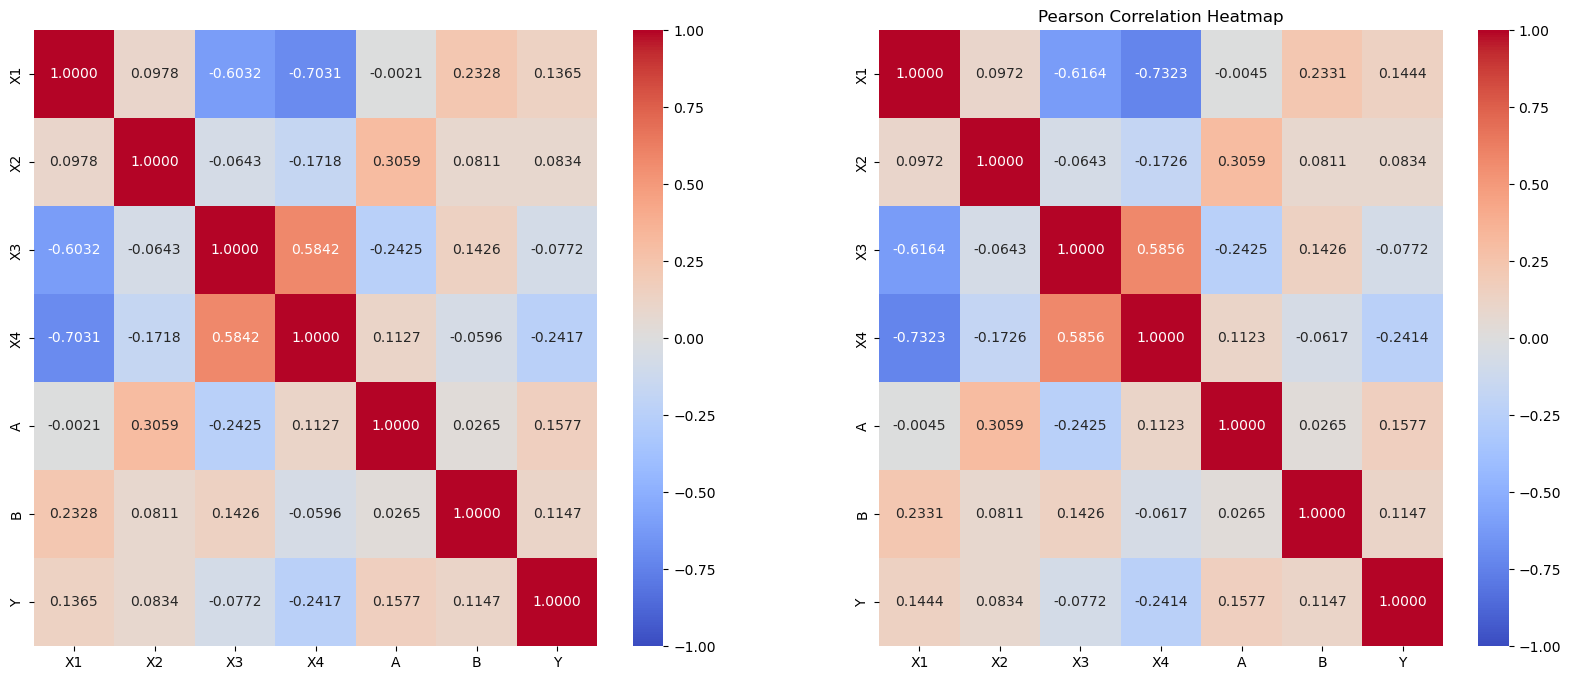

In [429]:
index = 0
df = pd.DataFrame(encoder(torch.tensor(datasets[index][['X1','X2','X3','X4','A','B']].values, dtype=torch.float32)).detach().numpy(), columns=['X1', 'X2', 'X3', 'X4'])
df_A_B_Y = datasets[index].copy()[['A', 'B', 'Y']].reset_index(drop=True)
df = pd.concat([df, df_A_B_Y], axis=1)
correlation_matrix = df.corr()
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[index].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

In [430]:
num_epochs = 30
adversaryA.train()

gradient_norms_advA = []
epochs_advA = []

In [431]:
for epoch in range(num_epochs):

    total_gradient_norm = 0.0
    num_batches = 0

    for data, labels in dataloader: 
        adversaryA.zero_grad()
        x_recon = encoder(data)
        adv_predA = adversaryA(x_recon.detach())
        laA = criterion_advA(adv_predA, data[:,4].view(-1,1).float())
        laA.backward()
        
        batch_gradient_norm = 0.0
        for p in adversaryA.parameters():
            if p.grad is not None:
                batch_gradient_norm += p.grad.data.norm(2).item() ** 2
        batch_gradient_norm = batch_gradient_norm ** 0.5
        total_gradient_norm += batch_gradient_norm
        num_batches += 1

        optimizer_advA.step()

    average_gradient_norm = total_gradient_norm / num_batches
    gradient_norms_advA.append(average_gradient_norm)
    epochs_advA.append(epoch)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss Adv A: {laA.item():.4f}')

Epoch [1/30], Loss Adv A: 0.4767
Epoch [2/30], Loss Adv A: 0.4986
Epoch [3/30], Loss Adv A: 0.4970
Epoch [4/30], Loss Adv A: 0.4211
Epoch [5/30], Loss Adv A: 0.4467
Epoch [6/30], Loss Adv A: 0.5170
Epoch [7/30], Loss Adv A: 0.5186
Epoch [8/30], Loss Adv A: 0.3696
Epoch [9/30], Loss Adv A: 0.5051
Epoch [10/30], Loss Adv A: 0.4938
Epoch [11/30], Loss Adv A: 0.4577
Epoch [12/30], Loss Adv A: 0.4273
Epoch [13/30], Loss Adv A: 0.4463
Epoch [14/30], Loss Adv A: 0.4119
Epoch [15/30], Loss Adv A: 0.4262
Epoch [16/30], Loss Adv A: 0.4965
Epoch [17/30], Loss Adv A: 0.4553
Epoch [18/30], Loss Adv A: 0.4152
Epoch [19/30], Loss Adv A: 0.4200
Epoch [20/30], Loss Adv A: 0.3897
Epoch [21/30], Loss Adv A: 0.4250
Epoch [22/30], Loss Adv A: 0.4358
Epoch [23/30], Loss Adv A: 0.4122
Epoch [24/30], Loss Adv A: 0.3843
Epoch [25/30], Loss Adv A: 0.4572
Epoch [26/30], Loss Adv A: 0.4501
Epoch [27/30], Loss Adv A: 0.4579
Epoch [28/30], Loss Adv A: 0.4105
Epoch [29/30], Loss Adv A: 0.4021
Epoch [30/30], Loss Adv

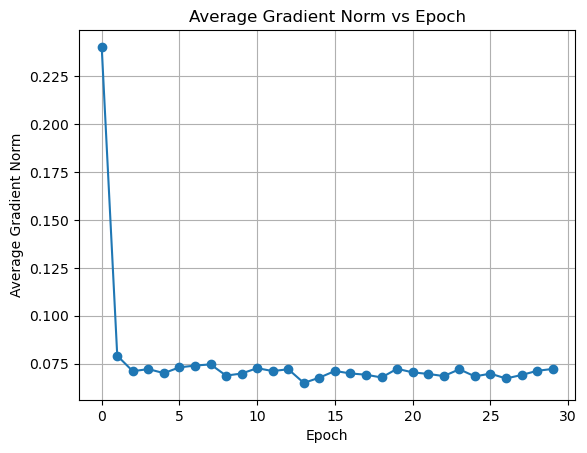

In [432]:
plt.plot(list(range(num_epochs)), gradient_norms_advA, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

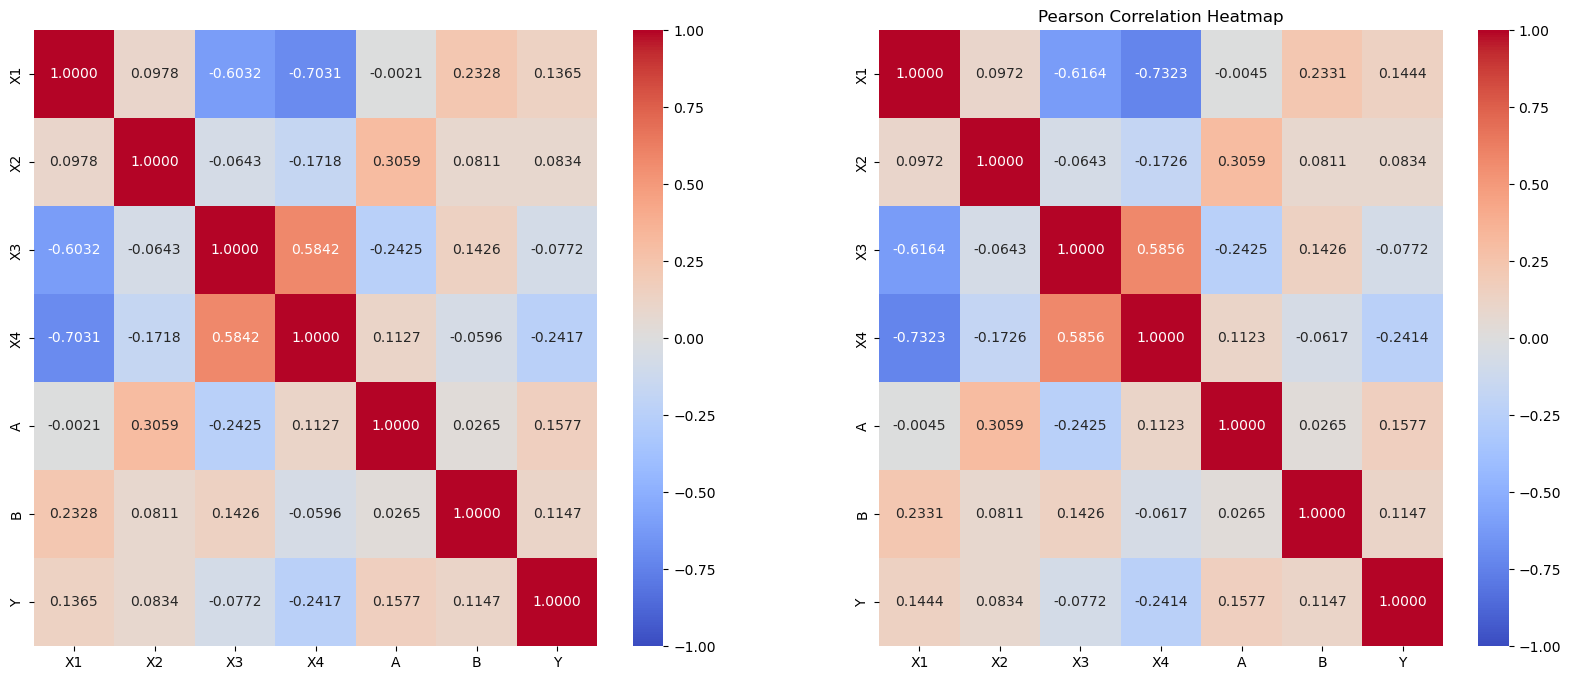

In [433]:
index = 0
df = pd.DataFrame(encoder(torch.tensor(datasets[index][['X1','X2','X3','X4','A','B']].values, dtype=torch.float32)).detach().numpy(), columns=['X1', 'X2', 'X3', 'X4'])
df_A_B_Y = datasets[index].copy()[['A', 'B', 'Y']].reset_index(drop=True)
df = pd.concat([df, df_A_B_Y], axis=1)
correlation_matrix = df.corr()
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[index].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

In [434]:
num_epochs = 30
adversaryB.train()

gradient_norms_advB = []
epochs_advB = []

In [435]:
for epoch in range(num_epochs):

    total_gradient_norm = 0.0
    num_batches = 0

    for data, labels in dataloader: 
        adversaryB.zero_grad()
        x_recon = encoder(data)
        adv_predB = adversaryB(x_recon.detach())
        laB = criterion_advB(adv_predB, data[:,4].view(-1,1).float())
        laB.backward()
        
        batch_gradient_norm = 0.0
        for p in adversaryB.parameters():
            if p.grad is not None:
                batch_gradient_norm += p.grad.data.norm(2).item() ** 2
        batch_gradient_norm = batch_gradient_norm ** 0.5
        total_gradient_norm += batch_gradient_norm
        num_batches += 1

        optimizer_advB.step()

    average_gradient_norm = total_gradient_norm / num_batches
    gradient_norms_advB.append(average_gradient_norm)
    epochs_advB.append(epoch)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss Adv: {laB.item():.4f}')

Epoch [1/30], Loss Adv: 0.4953
Epoch [2/30], Loss Adv: 0.5069
Epoch [3/30], Loss Adv: 0.5125
Epoch [4/30], Loss Adv: 0.4657
Epoch [5/30], Loss Adv: 0.4324
Epoch [6/30], Loss Adv: 0.4858
Epoch [7/30], Loss Adv: 0.4392
Epoch [8/30], Loss Adv: 0.4816
Epoch [9/30], Loss Adv: 0.5229
Epoch [10/30], Loss Adv: 0.4771
Epoch [11/30], Loss Adv: 0.4732
Epoch [12/30], Loss Adv: 0.4332
Epoch [13/30], Loss Adv: 0.4672
Epoch [14/30], Loss Adv: 0.4530
Epoch [15/30], Loss Adv: 0.3969
Epoch [16/30], Loss Adv: 0.4355
Epoch [17/30], Loss Adv: 0.4450
Epoch [18/30], Loss Adv: 0.4482
Epoch [19/30], Loss Adv: 0.4387
Epoch [20/30], Loss Adv: 0.4369
Epoch [21/30], Loss Adv: 0.4102
Epoch [22/30], Loss Adv: 0.3910
Epoch [23/30], Loss Adv: 0.4560
Epoch [24/30], Loss Adv: 0.3848
Epoch [25/30], Loss Adv: 0.3900
Epoch [26/30], Loss Adv: 0.4554
Epoch [27/30], Loss Adv: 0.3928
Epoch [28/30], Loss Adv: 0.3574
Epoch [29/30], Loss Adv: 0.3908
Epoch [30/30], Loss Adv: 0.5121


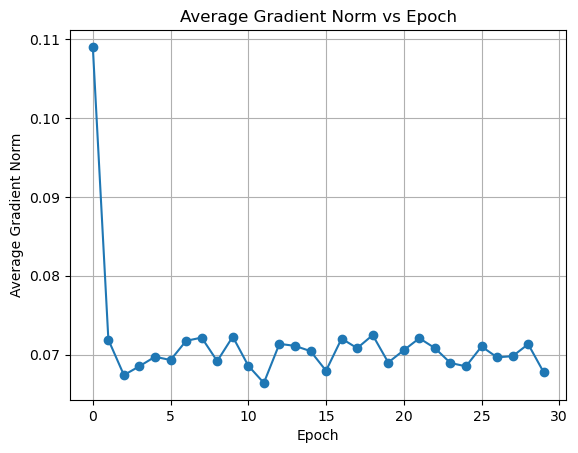

In [436]:
plt.plot(list(range(num_epochs)), gradient_norms_advB, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

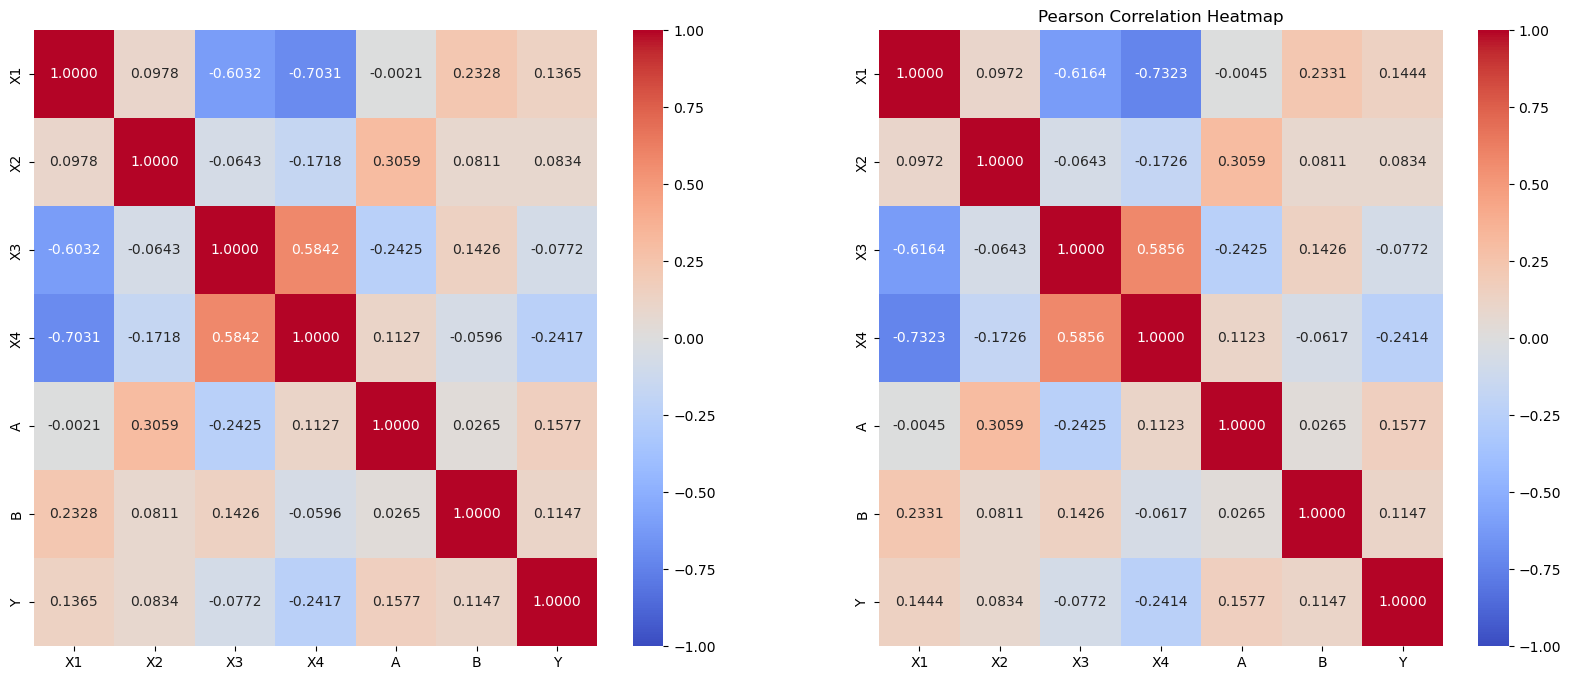

In [437]:
index = 0
df = pd.DataFrame(encoder(torch.tensor(datasets[index][['X1','X2','X3','X4','A','B']].values, dtype=torch.float32)).detach().numpy(), columns=['X1', 'X2', 'X3', 'X4'])
df_A_B_Y = datasets[index].copy()[['A', 'B', 'Y']].reset_index(drop=True)
df = pd.concat([df, df_A_B_Y], axis=1)
correlation_matrix = df.corr()
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[index].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

In [438]:
num_epochs = 50
encoder.train()
predictor.train()
adversaryA.train()
adversaryB.train()

gradient_norms_advA = []
gradient_norms_advB = []
gradient_norms_enc = []
gradient_norms_pred = []
epochs_total = []

In [474]:
for epoch in range(num_epochs):
    
    total_gradient_norm_A = 0.0
    total_gradient_norm_B = 0.0
    total_gradient_norm_enc = 0.0
    total_gradient_norm_pred = 0.0
    num_batches_adv = 0
    num_batches_other = 0

    for data, labels in dataloader: 
        adversaryA.zero_grad()
        adversaryB.zero_grad()
        x_recon = encoder(data)
        adv_predA = adversaryA(x_recon)
        adv_predB = adversaryB(x_recon)
        laA = criterion_advA(adv_predA, data[:,4].view(-1,1).float())
        laB = criterion_advB(adv_predB, data[:,5].view(-1,1).float())
        laA.backward(retain_graph=True)
        laB.backward()
        
        batch_gradient_norm_A = 0.0
        for p in adversaryA.parameters():
            if p.grad is not None:
                batch_gradient_norm_A += p.grad.data.norm(2).item() ** 2
        batch_gradient_norm_A = batch_gradient_norm_A ** 0.5
        total_gradient_norm_A += batch_gradient_norm_A

        batch_gradient_norm_B = 0.0
        for p in adversaryB.parameters():
            if p.grad is not None:
                batch_gradient_norm_B += p.grad.data.norm(2).item() ** 2
        batch_gradient_norm_B = batch_gradient_norm_B ** 0.5
        total_gradient_norm_B += batch_gradient_norm_B

        num_batches_adv += 1

#         torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
#         torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
#         torch.nn.utils.clip_grad_norm_(adversaryA.parameters(), 1.0)
#         torch.nn.utils.clip_grad_norm_(adversaryB.parameters(), 1.0)

        optimizer_advA.step()
        optimizer_advB.step()
        
    for data, labels in dataloader: 
        pass
    
    encoder.zero_grad()
    predictor.zero_grad()
    x_recon = encoder(data)
    y_pred = predictor(x_recon)
    adv_predA = adversaryA(x_recon)
    adv_predB = adversaryB(x_recon)

    lx = criterion_enc(x_recon, data[:,:4])
    lp = criterion_pred(y_pred, labels)
    laA = criterion_advA(adv_predA, data[:,4].view(-1,1).float())
    laB = criterion_advB(adv_predB, data[:,5].view(-1,1).float())
    
#     combined_loss = lx + lp - (100 * (laA + laB))
    combined_loss = lx + lp - (laA + laB)
    combined_loss.backward()

    for p in adversaryA.parameters():
        if p.grad is not None:
            batch_gradient_norm_A += p.grad.data.norm(2).item() ** 2
    batch_gradient_norm_A = batch_gradient_norm_A ** 0.5
    total_gradient_norm_A += batch_gradient_norm_A
    
    for p in adversaryB.parameters():
        if p.grad is not None:
            batch_gradient_norm_B += p.grad.data.norm(2).item() ** 2
    batch_gradient_norm_B = batch_gradient_norm_B ** 0.5
    total_gradient_norm_B += batch_gradient_norm_B

    batch_gradient_norm_enc = 0.0
    for p in encoder.parameters():
        if p.grad is not None:
            batch_gradient_norm_enc += p.grad.data.norm(2).item() ** 2
    batch_gradient_norm_enc = batch_gradient_norm_enc ** 0.5
    total_gradient_norm_enc += batch_gradient_norm_enc

    batch_gradient_norm_pred = 0.0
    for p in predictor.parameters():
        if p.grad is not None:
            batch_gradient_norm_pred += p.grad.data.norm(2).item() ** 2
    batch_gradient_norm_pred = batch_gradient_norm_pred ** 0.5
    total_gradient_norm_pred += batch_gradient_norm_pred


    num_batches_other += 1
    num_batches_adv += 1

#     torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
#     torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
#     torch.nn.utils.clip_grad_norm_(adversaryA.parameters(), 1.0)
#     torch.nn.utils.clip_grad_norm_(adversaryB.parameters(), 1.0)

    optimizer_pred.step()
    optimizer_enc.step()

    
    average_gradient_norm_A = total_gradient_norm_A / num_batches_adv
    gradient_norms_advA.append(average_gradient_norm_A)

    average_gradient_norm_B = total_gradient_norm_B / num_batches_adv
    gradient_norms_advB.append(average_gradient_norm_B)
    
    average_gradient_norm_enc = total_gradient_norm_enc / num_batches_other
    gradient_norms_enc.append(average_gradient_norm_enc)

    average_gradient_norm_pred = total_gradient_norm_pred / num_batches_other
    gradient_norms_pred.append(average_gradient_norm_pred)

    epochs_total.append(epoch)

#     print("num_batches_adv",num_batches_adv)
#     print("num_batches_other",num_batches_other)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss A: {laA.item():.4f}, Loss B: {laB.item():.4f}, Loss Recon: {lx.item():.4f}, Loss P: {lp.item():.4f}, Loss Comb: {combined_loss.item():.4f}')

Epoch [1/50], Loss A: 0.6327, Loss B: 0.3849, Loss Recon: 0.0331, Loss P: 0.4774, Loss Comb: -0.5071
Epoch [2/50], Loss A: 0.6331, Loss B: 0.3846, Loss Recon: 0.0330, Loss P: 0.4774, Loss Comb: -0.5074
Epoch [3/50], Loss A: 0.6335, Loss B: 0.3844, Loss Recon: 0.0330, Loss P: 0.4774, Loss Comb: -0.5076
Epoch [4/50], Loss A: 0.6339, Loss B: 0.3843, Loss Recon: 0.0330, Loss P: 0.4774, Loss Comb: -0.5078
Epoch [5/50], Loss A: 0.6341, Loss B: 0.3844, Loss Recon: 0.0330, Loss P: 0.4774, Loss Comb: -0.5080
Epoch [6/50], Loss A: 0.6341, Loss B: 0.3845, Loss Recon: 0.0330, Loss P: 0.4774, Loss Comb: -0.5083
Epoch [7/50], Loss A: 0.6340, Loss B: 0.3846, Loss Recon: 0.0329, Loss P: 0.4773, Loss Comb: -0.5085
Epoch [8/50], Loss A: 0.6338, Loss B: 0.3848, Loss Recon: 0.0329, Loss P: 0.4773, Loss Comb: -0.5085
Epoch [9/50], Loss A: 0.6335, Loss B: 0.3850, Loss Recon: 0.0330, Loss P: 0.4772, Loss Comb: -0.5083
Epoch [10/50], Loss A: 0.6331, Loss B: 0.3852, Loss Recon: 0.0332, Loss P: 0.4772, Loss Com

In [475]:
len(epochs_total)

250

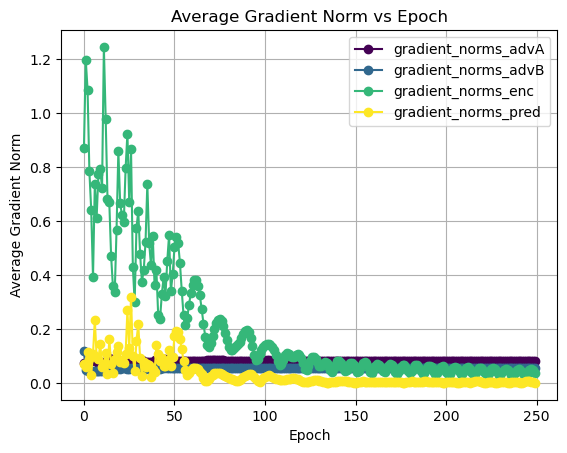

In [476]:
import matplotlib.cm as cm
colors = cm.viridis(np.linspace(0, 1, 4))
plt.plot(list(range(len(epochs_total))), gradient_norms_advA, color=colors[0], marker='o', label='gradient_norms_advA')
plt.plot(list(range(len(epochs_total))), gradient_norms_advB, color=colors[1], marker='o', label='gradient_norms_advB')
plt.plot(list(range(len(epochs_total))), gradient_norms_enc, color=colors[2], marker='o', label='gradient_norms_enc')
plt.plot(list(range(len(epochs_total))), gradient_norms_pred, color=colors[3], marker='o', label='gradient_norms_pred')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

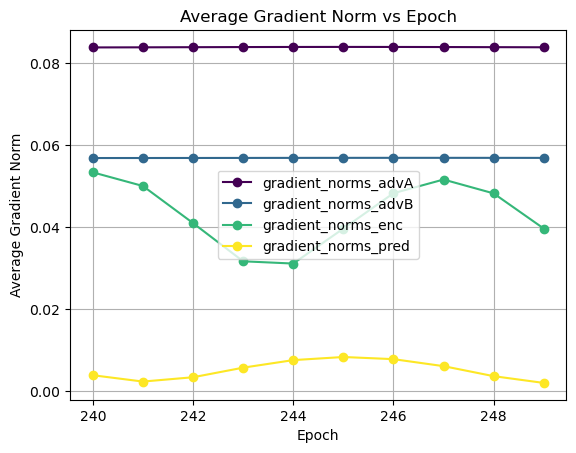

In [479]:
import matplotlib.cm as cm
colors = cm.viridis(np.linspace(0, 1, 4))
plt.plot(list(range(len(epochs_total)))[-10:], gradient_norms_advA[-10:], color=colors[0], marker='o', label='gradient_norms_advA')
plt.plot(list(range(len(epochs_total)))[-10:], gradient_norms_advB[-10:], color=colors[1], marker='o', label='gradient_norms_advB')
plt.plot(list(range(len(epochs_total)))[-10:], gradient_norms_enc[-10:], color=colors[2], marker='o', label='gradient_norms_enc')
plt.plot(list(range(len(epochs_total)))[-10:], gradient_norms_pred[-10:], color=colors[3], marker='o', label='gradient_norms_pred')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

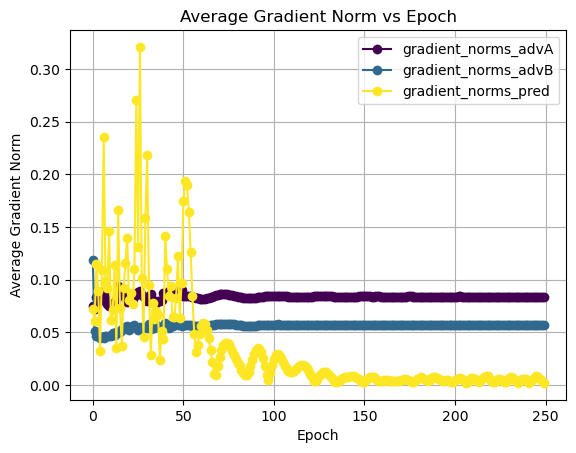

In [480]:
import matplotlib.cm as cm
colors = cm.viridis(np.linspace(0, 1, 4))
plt.plot(list(range(len(epochs_total))), gradient_norms_advA, color=colors[0], marker='o', label='gradient_norms_advA')
plt.plot(list(range(len(epochs_total))), gradient_norms_advB, color=colors[1], marker='o', label='gradient_norms_advB')
# plt.plot(list(range(len(epochs_total))), gradient_norms_enc, color=colors[2], marker='o', label='gradient_norms_enc')
plt.plot(list(range(len(epochs_total))), gradient_norms_pred, color=colors[3], marker='o', label='gradient_norms_pred')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

In [481]:
# index = 0
# df = pd.DataFrame(encoder(torch.tensor(datasets[index][['X1','X2','X3','X4','A','B']].values, dtype=torch.float32)).detach().numpy(), columns=['X1', 'X2', 'X3', 'X4'])
# df_A_B_Y = datasets[index].copy()[['A', 'B', 'Y']].reset_index(drop=True)
# df = pd.concat([df, df_A_B_Y], axis=1)
# correlation_matrix = df.corr()
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
# plt.title('Pearson Correlation Heatmap')
# plt.show()

In [482]:
index = 0
df_original = datasets[index].copy()

dataset = CustomDataset(df_original)
dataloader = DataLoader(dataset, batch_size=256, shuffle=False)

encoder_outputs = []
encoder.eval()
with torch.no_grad():
    for batch_X, _ in dataloader:
        output = encoder(batch_X)
        encoder_outputs.append(output)
encoder_outputs = torch.cat(encoder_outputs, dim=0)
print(encoder_outputs.shape)

encoder_outputs_np = encoder_outputs.numpy()
df = pd.DataFrame(encoder_outputs_np, columns=['X1', 'X2', 'X3', 'X4'])

df_A_B = df_original[['A', 'B', 'Y']].reset_index(drop=True)
df = pd.concat([df, df_A_B], axis=1)

correlation_matrix = df.corr()

torch.Size([100000, 4])


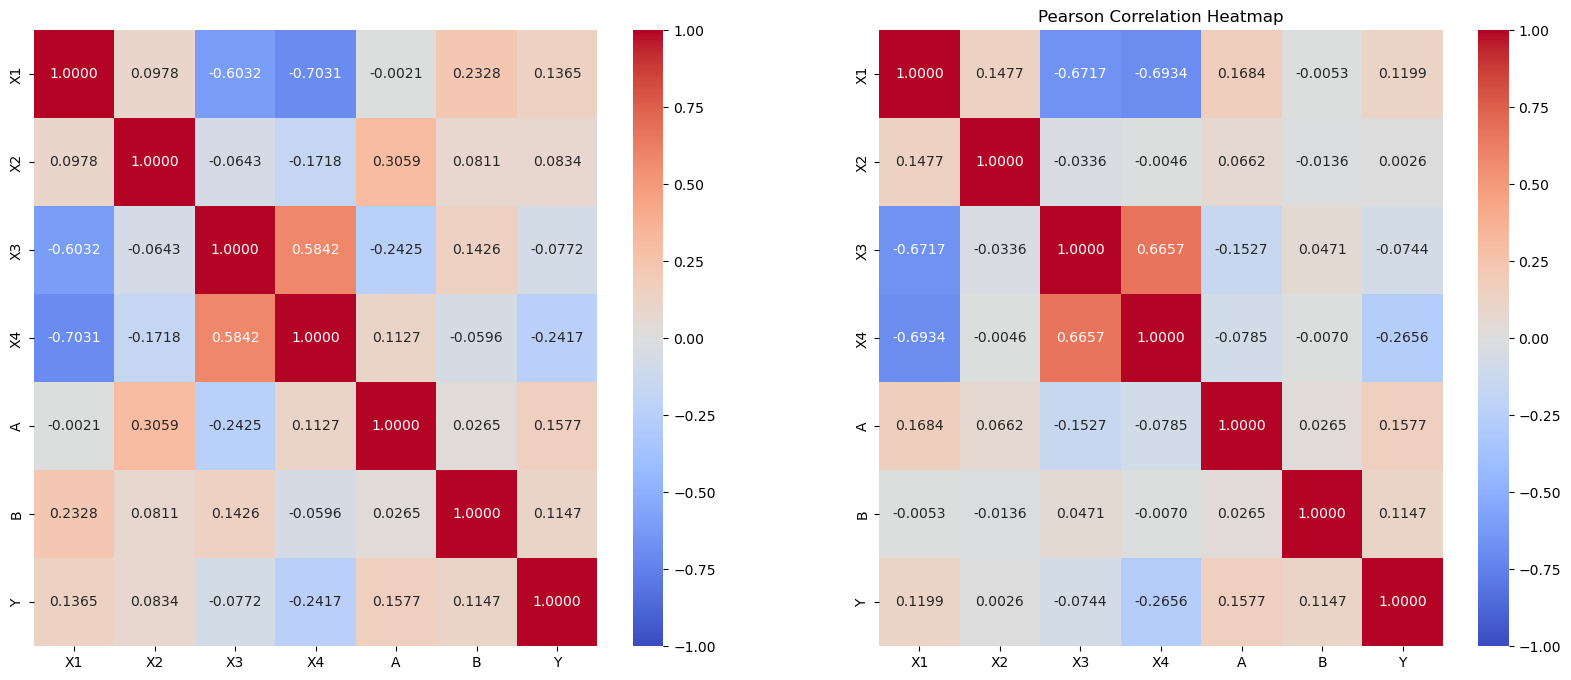

In [445]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[0].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

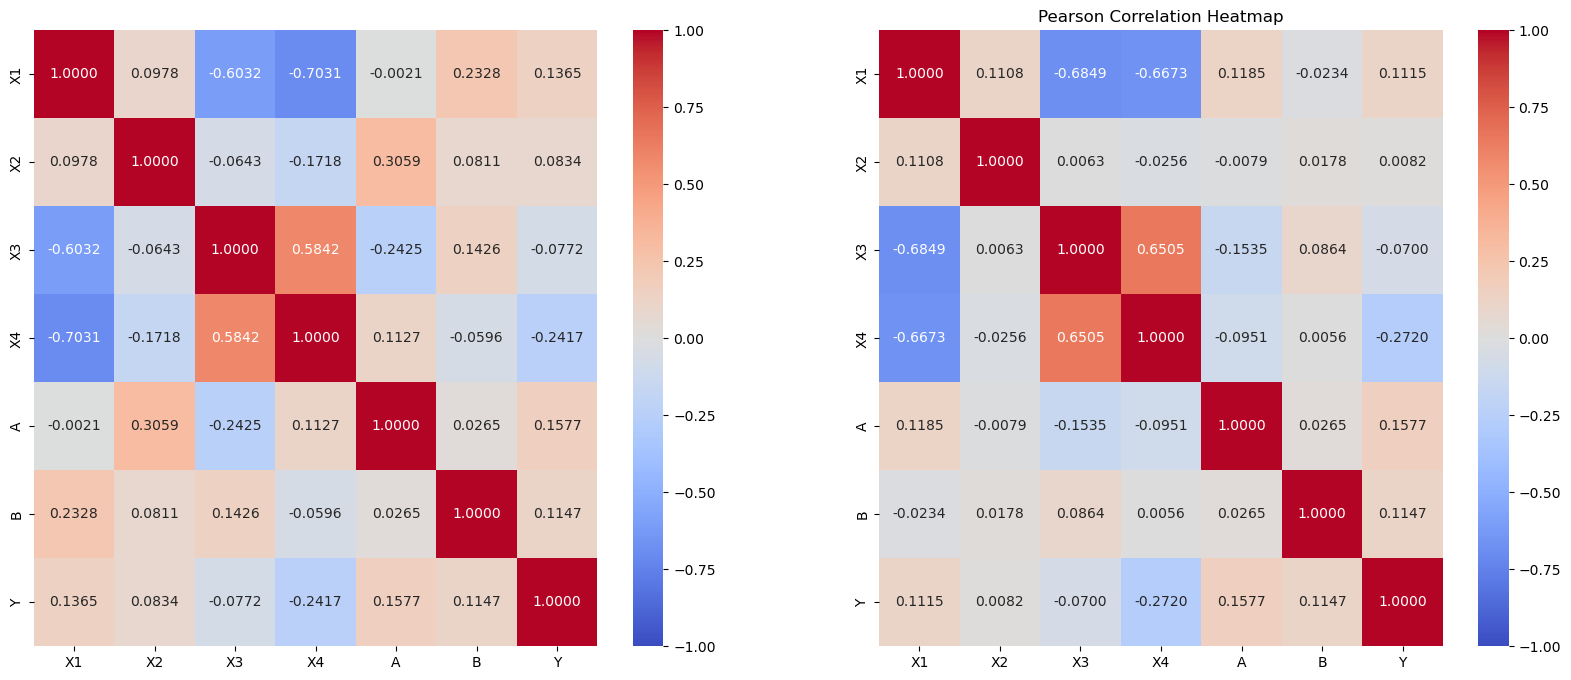

In [452]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[0].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

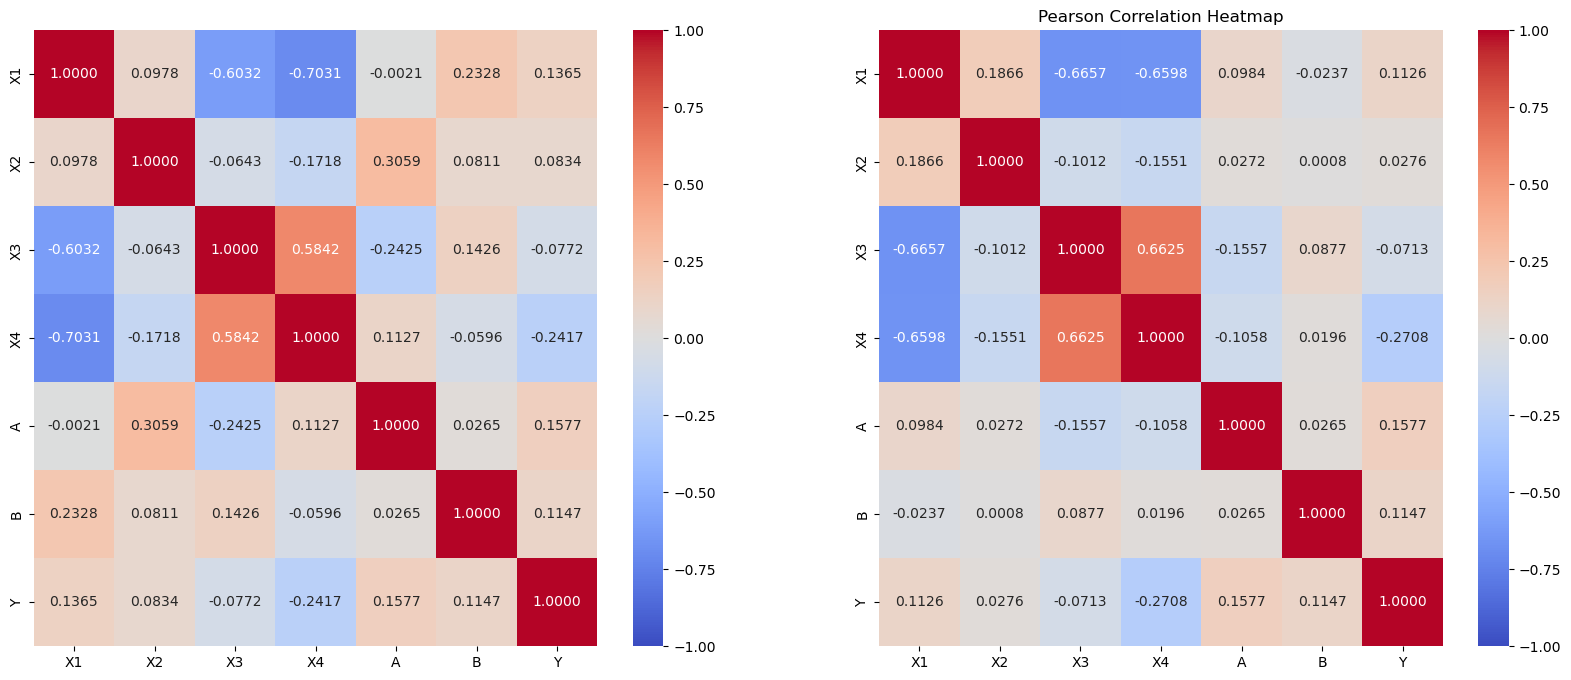

In [467]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[0].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

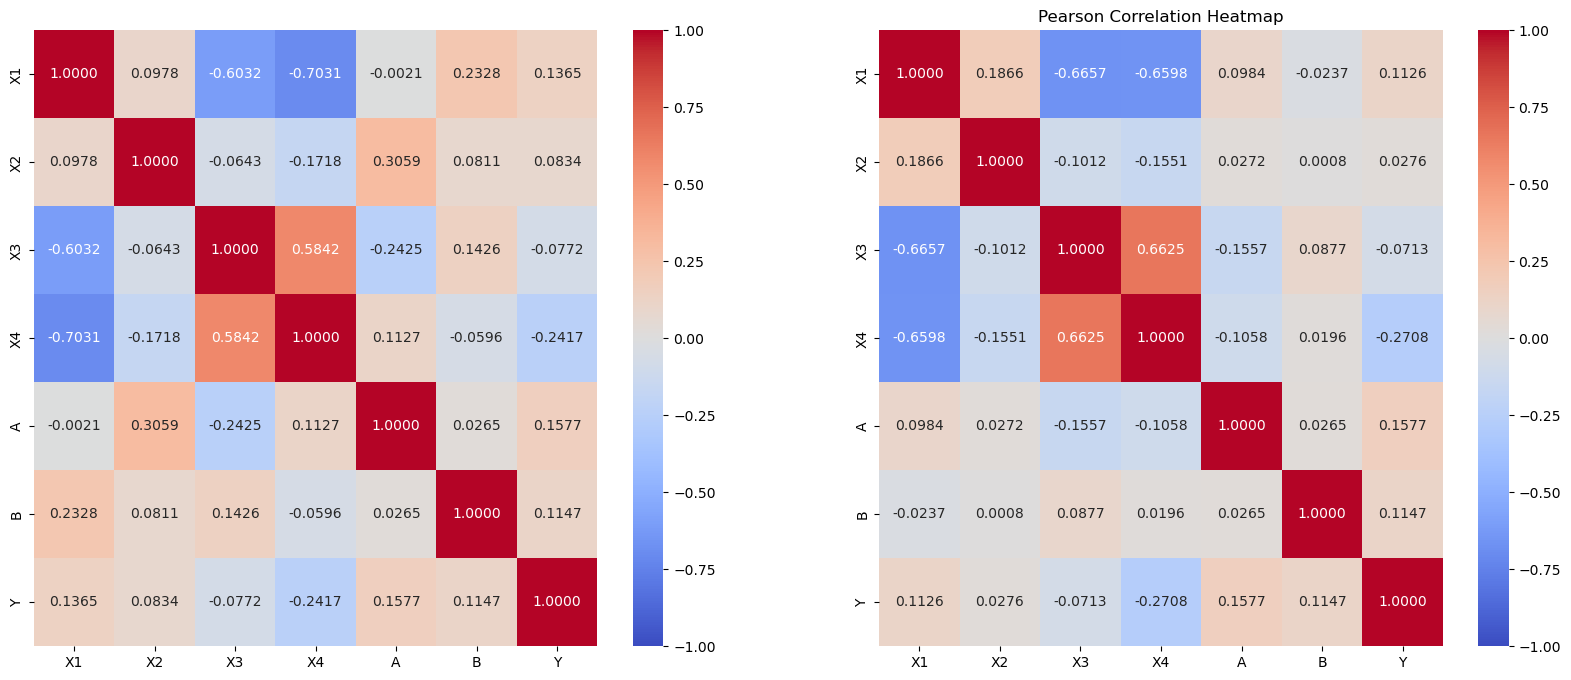

In [473]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[0].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

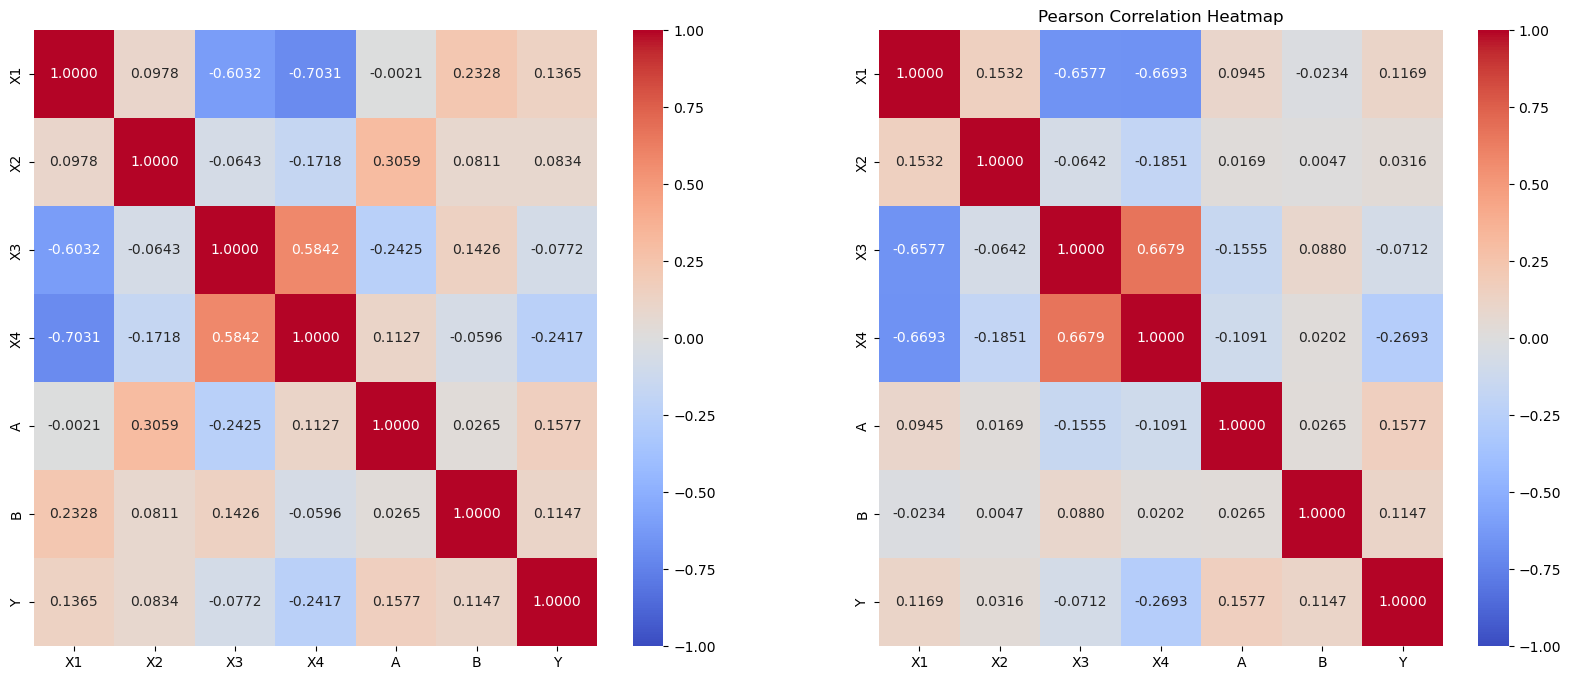

In [483]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[0].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

In [177]:
loss_fn = nn.BCELoss()

In [ ]:
encoder(torch.tenso)
loss_fn()

In [182]:
y = np.random.randint(0,2, size=10000)
y

array([0, 1, 1, ..., 0, 0, 1])

In [184]:
y_hat = 1-y
y_hat

array([1, 0, 0, ..., 1, 1, 0])

In [185]:
from sklearn.metrics import log_loss

In [189]:
log_loss(y,y_hat)

36.043653389117146

In [187]:
log_loss(y,y)

2.2204460492503136e-16